Code for Variance Hammer's Eldar Codex Review
========================
This code is for the analysis of the effect of the changes to the Wave Serpent's Serpent Shield, as well as the impact of Dire Avengers being able to Overwatch at BS 2. The text of the review itself is at: http://www.variancehammer.com/ . Note that because this analysis uses random numbers, any results you obtain may differ from those on the blog posting due to random chance.


**Import the necessary libraries**  

These are easily obtained using the Anaconda Python Distribution, which is available free from http://www.continuum.io

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import random as rand
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

As there is no Variance Hammer library available (yet), we need to define a couple useful functions. *DiceRoller()* is a function to roll an arbitrary number of d6 dice. *Shooting()* does what it says on the tin - it takes a number of shots, rolls the appropriate number of d6 dice, checks those results against Ballistic Skill, and if the shots are twin-linked, rerolls as appropriate. Note that at the moment this function **does not** work for BS values above 6.

In [3]:
def DiceRoller(n_rolls):
	try:
		dice = int(n_rolls)
	except ValueError:
		print("Number of dice to roll needs to be an integer")
	rolls = np.random.random_integers(6, size=(1.,dice))
	return rolls

In [4]:
def Shooting(BS, n_shots, twinlinked):
    try:
        BS = int(BS)
    except ValueError:
        print("BS needs to be an integer")
    try:
        n_shots = int(n_shots)
    except ValueError:
        print("Number of shots needs to be an integer")
    if twinlinked == "Y":
        shots = DiceRoller(n_shots)
        shots[shots > BS] = rand.randint(1,6)
    elif twinlinked =="N":
        shots = DiceRoller(n_shots)
    else:
        print("Designate Twin-linking with Y or N. Assumed to be off.")
        shots = DiceRoller(n_shots)

    hits = np.sum(shots.__ge__(7-BS))
    return shots,hits

**Wave Serpent Changes**

Finally, we get to the actual analysis. Here, we build a function for an "old" 6th edition Wave Serpent firing both a twin-linked Scatter Laser and it's Serpent Shield for a turn, handling the twin-linking induced by Laser Lock if the Scatter Laser hits. Then we apply this for four turns worth of shooting.

The "new" 7th edition Wave Serpent needs a slightly different function, as Laser Lock is no longer a rule, and we need to know if the Serpent Shield is available to fire. Then we apply the same idea - four turns of shooting, one with the Shield firing, the others without.

Once we have those, we simulate a number of games, collect the results, and compare them using a histogram - 6th edition is in purple, and 7th edition is in Tarheel Blue.

In [5]:
def OldWS():
    ScatterLaser = Shooting(4,4,'Y')
    if ScatterLaser[1] >= 1:
        SS = Shooting(4,(rand.randint(1,6)+1),'Y')
    else:
        SS = Shooting(4,(rand.randint(1,6)+1),'N')
    Total = ScatterLaser[1] + SS[1]
    return Total

def OldWSFourTurns():
    Turn1 = OldWS()
    Turn2 = OldWS()
    Turn3 = OldWS()
    Turn4 = OldWS()
    Total = Turn1 + Turn2 + Turn3 + Turn4
    return Total

In [6]:
def NewWS(shield):
    ScatterLaser = Shooting(4,4,'Y')
    if shield == 1:
        SS = Shooting(4,(rand.randint(1,6)+rand.randint(1,6)),'N')
        Total = ScatterLaser[1] + SS[1]
    else:
        Total = ScatterLaser[1]
    return Total

def NewWSFourTurns():
    Turn1 = NewWS(shield=1)
    Turn2 = NewWS(shield=0)
    Turn3 = NewWS(shield=0)
    Turn4 = NewWS(shield=0)
    Total = Turn1 + Turn2 + Turn3 + Turn4
    return Total

In [7]:
runs = 2500

In [8]:
wscomparison = np.empty([runs,2])

In [9]:
for i in range(runs):
    wscomparison[i][0] = OldWSFourTurns()
    wscomparison[i][1] = NewWSFourTurns()

In [10]:
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

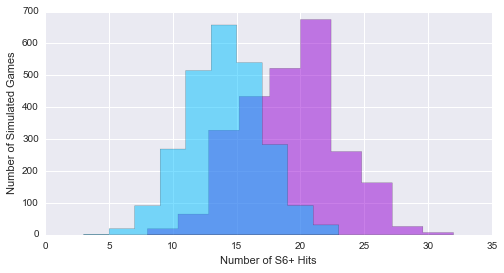

In [11]:
plt.hist(wscomparison[:,0],alpha=0.50,bins=10,color="DarkViolet",histtype="stepfilled")
plt.hist(wscomparison[:,1],alpha=0.50,bins=10,color="DeepSkyBlue",histtype="stepfilled")
plt.xlabel("Number of S6+ Hits")
plt.ylabel("Number of Simulated Games")

**Dire Avenger BS 2 Overwatch**

This analysis is actually much easier, as it's just two sets of shooting, one at BS1, the other at BS2. Again, we use a histogram to visualize the difference in the two distributions.

In [12]:
overwatch = np.empty([runs,2])

In [13]:
for k in range(runs):
    overwatch[k][0] = Shooting(1,10,'N')[1]
    overwatch[k][1] = Shooting(2,10,'N')[1]

In [14]:
print overwatch

[[ 3.  5.]
 [ 2.  5.]
 [ 2.  4.]
 ..., 
 [ 3.  3.]
 [ 2.  3.]
 [ 2.  0.]]


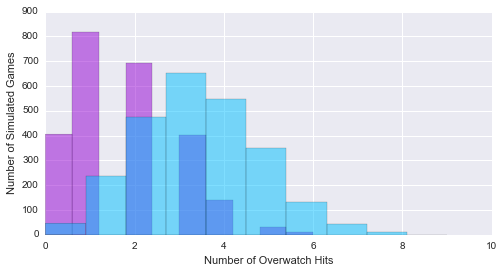

In [15]:
plt.hist(overwatch[:,0],bins=10,alpha=0.50,color="DarkViolet")
plt.hist(overwatch[:,1],bins=10,alpha=0.50,color="DeepSkyBlue")
plt.xlabel("Number of Overwatch Hits")
plt.ylabel("Number of Simulated Games")

But what about Counter-attack? Lets expand that overwatch out to a full turn of close combat - overwatch, plus the first round of hits. We're going to cheat a bit and use the shooting function, just engineered to give 4+ hits, which is probably what the Dire Avengers will be doing in close combat. There are 11 close combat attacks (2 * 5 Dire Avengers + Exarch attack) with Counter-attack, and 6 without.

In [21]:
avengercc = np.empty([runs,2])
def daccBS1():
    overwatch = Shooting(1,10,'N')[1]
    closecombat = Shooting(3,11,'N')[1]
    total = overwatch + closecombat
    return total
def daccBS2():
    overwatch = Shooting(2,10,'N')[1]
    closecombat = Shooting(3,6,'N')[1]
    total = overwatch + closecombat
    return total

for n in range(runs):
    avengercc[n][0] = daccBS1()
    avengercc[n][1] = daccBS2()
    

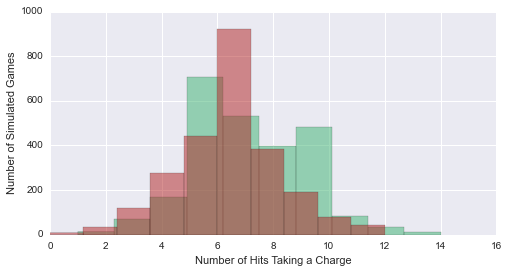

In [23]:
plt.hist(avengercc[:,0],bins=10,alpha=0.50,color="MediumSeaGreen")
plt.hist(avengercc[:,1],bins=10,alpha=0.50,color="FireBrick")
plt.xlabel("Number of Hits Taking a Charge")
plt.ylabel("Number of Simulated Games")